In [1]:
import sys
import numpy as np
sys.path.append('../DE_PyCharm')
from Comms_System import Comms_System
from train_decision_making import train_DM_model
from DE_minibatch import DE
#from DE import DE
from objective_functions import MSE
from objective_functions import crossEntropy
from Network import NeuralNetwork
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 1334
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
sigma = 2

# calibrate
gain_factor = np.max(np.convolve(CS.h, CS.h))

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample(v=False)
Tx = np.convolve(upsampled, CS.h)

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)
downsampled = CS.downsample(Rx)/gain_factor
Rx_ = Rx/gain_factor

blocks = CS.get_periods(Rx_)
X = np.array(blocks)

In [3]:
X = np.array(blocks)
y = symbol_seq
classes = np.array(symbol_set)
num_classes = len(classes)
sizes = [8, 8, 4]
sizes[-1] = num_classes

# Makes a dictionary that maps a number to each symbol e.g. 3: 0
class_idx = {v: i for i, v in enumerate(classes)}

# Maps class indexes to each value in targets
y = np.array([class_idx[v] for v in y])

# Converts to one-hot-encoded
y = np.eye(num_classes)[y]

# split train-test
splitlen = int(X.shape[0] * 0.75)
Xtrain, ytrain = X[:splitlen], y[:splitlen]
Xtest, ytest = X[splitlen:], y[splitlen:]

Rising 0.4221556886227545
Rising 0.7155688622754491
Rising 0.7574850299401198
Rising 0.7754491017964071
Rising 0.7994011976047904
Rising 0.8383233532934131
Rising 0.8562874251497006
Rising 0.8832335329341318
Rising 0.8982035928143712
Optimal number of iterations: 2292
Best accuracy: 0.8982035928143712
Accuracy at stop: 0.8922155688622755


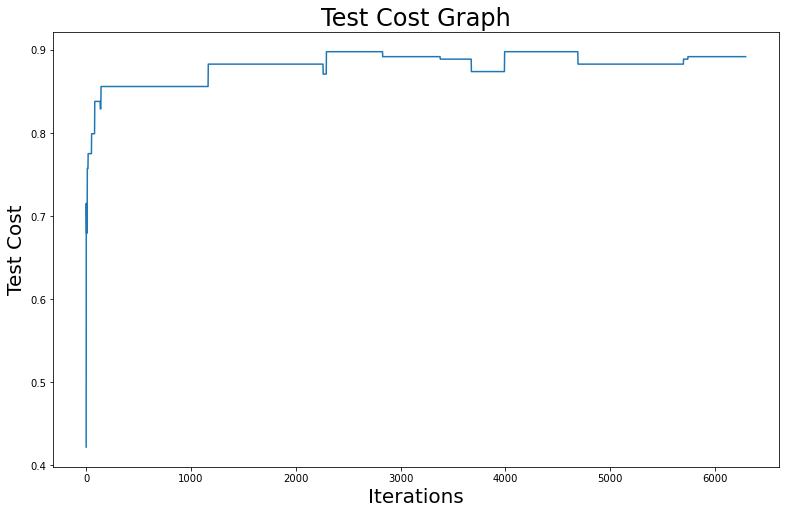

In [9]:
optimizer = 'DE'
early_stop = True

if optimizer == 'DE':
    D = DE(objective_function=crossEntropy, sizes=sizes, pop_size=50, F=0.55, cr=0.85,
           X=Xtrain, y=ytrain, Xtest=Xtest, ytest=ytest, type='classification', afunc='relu')
    
    if early_stop:
        best_agent, opt_agent = D.early_stop_training(patience=4000, batch_size=Xtrain.shape[0], measure='accuracy')
    else:
        best_agent = D.evolution(num_epochs=1001, batch_size=Xtrain.shape[0], verbose=True, print_epoch=100)
        D.evaluate()
    
elif optimizer == 'BP':
    NN = NeuralNetwork(sizes=[8,8,4], afunc='relu')
    NN.train_loop(Xtrain, ytrain, Xtest, ytest, epochs=100, batch_size=Xtrain.shape[0], 
                  cost=True, acc=True, plot=True)
    best_agent = NN

In [10]:
# Get predictions
predictions = opt_agent.feedforward(Xtest).argmax(axis=1)
true = ytest.argmax(axis=1)

# Convert back to symbols
predicted_symbols = classes[predictions]
true_values = classes[true]
# print(predicted_symbols, true_values)
correct_preds = np.equal(true_values, predicted_symbols)
print("Accuracy: ", (sum(correct_preds) / len(true_values)) * 100, "%")

Accuracy:  89.82035928143712 %


# Error Rate

In [ ]:
for i in range(5):
    
    symbol_set = [3, 1, -1, -3] # all symbols that we use
    num_symbols = 10000
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
    sigma = 3
    classes = np.array(symbol_set)

    # calibrate
    gain_factor = np.max(np.convolve(CS.h, CS.h))

    # upsample symbol sequence and filter it on transmission side
    upsampled = CS.upsample(v=False)
    Tx = np.convolve(upsampled, CS.h)

    # Transmit the filtered signal (i.e. add noise)
    Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

    # Filter on receiver side
    Rx = np.convolve(Tx, CS.h)
    #downsampled = CS.downsample(Rx)/gain_factor
    Rx_ = Rx/gain_factor

    blocks = CS.get_periods(Rx_)
    X = np.array(blocks)
    euclid_decisions = CS.transmission(mode='euclidean', noise_level=sigma)
    NN_decisions = classes[D.best_agent.feedforward(X).argmax(axis=1)]
    
    print('Euclidean Distance Error Rate: {}%'.format((CS.evaluate(euclid_decisions)[1]*100).round(2)))
    print('Blocks Neural Net Error Rate: {}%'.format((CS.evaluate(NN_decisions)[1]*100).round(2)))

In [ ]:
save_weights = True

if save_weights:
    D.save_params('block_decision_making_weights', 'block_decision_making_biases')